## Temperature Prediction
- [Data Source](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv)

In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

### Utility function to plot the data

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [4]:
## Load and check data

filename = 'daily_min_temperatures.csv'

count = 0
with open(filename, 'r') as csvfile:
    
    data = csv.reader(csvfile)
    
    for line in data:
        print(line)
        
        if count >= 5:
            break
#         count += 1

['Date', 'Temp']
['1981-01-01', '20.7']
['1981-01-02', '17.9']
['1981-01-03', '18.8']
['1981-01-04', '14.6']
['1981-01-05', '15.8']
['1981-01-06', '15.8']
['1981-01-07', '15.8']
['1981-01-08', '17.4']
['1981-01-09', '21.8']
['1981-01-10', '20.0']
['1981-01-11', '16.2']
['1981-01-12', '13.3']
['1981-01-13', '16.7']
['1981-01-14', '21.5']
['1981-01-15', '25.0']
['1981-01-16', '20.7']
['1981-01-17', '20.6']
['1981-01-18', '24.8']
['1981-01-19', '17.7']
['1981-01-20', '15.5']
['1981-01-21', '18.2']
['1981-01-22', '12.1']
['1981-01-23', '14.4']
['1981-01-24', '16.0']
['1981-01-25', '16.5']
['1981-01-26', '18.7']
['1981-01-27', '19.4']
['1981-01-28', '17.2']
['1981-01-29', '15.5']
['1981-01-30', '15.1']
['1981-01-31', '15.4']
['1981-02-01', '15.3']
['1981-02-02', '18.8']
['1981-02-03', '21.9']
['1981-02-04', '19.9']
['1981-02-05', '16.6']
['1981-02-06', '16.8']
['1981-02-07', '14.6']
['1981-02-08', '17.1']
['1981-02-09', '25.0']
['1981-02-10', '15.0']
['1981-02-11', '13.7']
['1981-02-12', '1

### PrePare Data

(3650,)
(3650,)


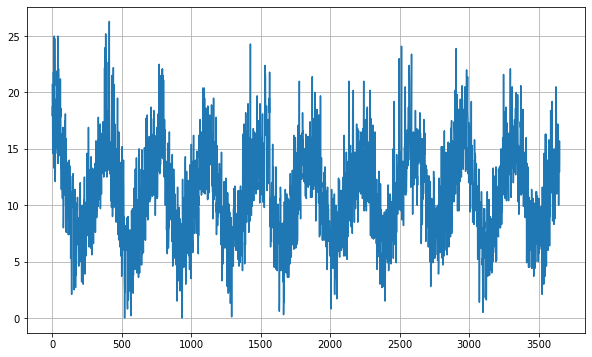

In [5]:
## Retrieve and store the data

series = []

with open(filename, 'r') as csvfile:
    
    # read the csv file
    data = csv.reader(csvfile)
    
    # skip the first line
    next(data)
    
    # append the data
    for line in data:
        # time.append()
        series.append(float(line[1]))
        
# get time data
time = range(1, len(series) + 1)

## convert into numpy arrays
series = np.array(series)
time = np.array(time)

# check the shape of the data
print(series.shape)
print(time.shape)

# plot the data 
plot_series(time, series)

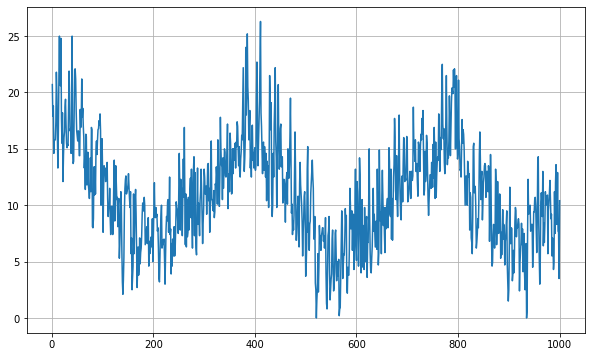

In [6]:
# zoom in and plot the data 
plot_series(time, series, start=0, end=1000)

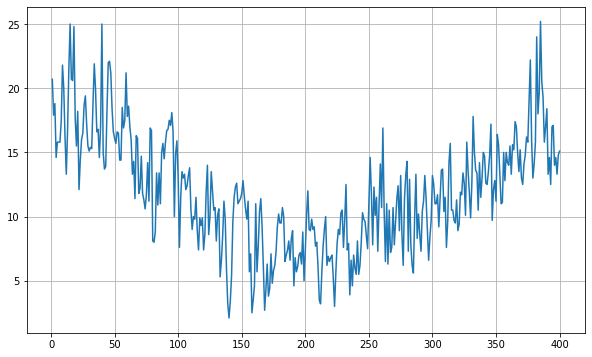

In [7]:
# zoom in and plot the data 
plot_series(time, series, start=0, end=400)

In [8]:
print(series.max(), series.min())

26.3 0.0


- We can see that the temperature data listed is per day
- The seasonality is annual i.e. 365 days
- Total data points is 3650 i.e. 10 years of data
- We will take 8 years of data for training and 2 years of data for validation

### Spitting the data
- splitting at 2920 for 8 years of data for training

In [9]:
split_time = 2920

train_series = series[:split_time]
train_time = time[:split_time]

valid_series = series[split_time:]
valid_time = time[split_time:]

print(train_series.shape, valid_series.shape)

(2920,) (730,)


### set up the parameters

In [10]:
window_size = 30 # start with monthly timeframe
batch_size = 64
buffer_size = 1000

### Pre-Processing for training

In [11]:
## function to generate datasets

def generate_windowed_dataset(series, buffer_size, batch_size, window_size):
    
    # generate data
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size=window_size + 1, shift=1, drop_remainder=True)
    
    # flatten the data
    dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
    
    # create features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # shuffle data
    dataset = dataset.shuffle(buffer_size=buffer_size)
    
    # batch 
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    return dataset

In [12]:
### create training dataset

train_dataset = generate_windowed_dataset(train_series, buffer_size, batch_size, window_size)

# check the data
for data in train_dataset.take(1):
    
    print('Feature Shape : {}'.format(data[0].shape))
    print('Label Shape : {}'.format(data[1].shape))

Feature Shape : (64, 30)
Label Shape : (64,)


## Build Model

In [13]:
## clear keras session

tf.keras.backend.clear_session()

# intialize model
model = tf.keras.models.Sequential([
    
    # convd1d layer
    tf.keras.layers.Conv1D(64, 3,
                           strides = 1,
                           padding='causal',
                           activation = 'relu',
                           input_shape =[window_size, 1]),
    
    # LSTM layers
    tf.keras.layers.LSTM(64, activation ='relu', return_sequences=True),
    tf.keras.layers.LSTM(64, activation ='relu'),
        
    # Dense Layers
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1),
    
    # lambda to format the output
    tf.keras.layers.Lambda(lambda x: x* 100.0)
    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
 lambda (Lambda)             (None, 1)                 0

In [15]:
## store the initial weights

init_weights = model.get_weights()

In [20]:
## Set up the learning rate parameter

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/window_size))

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit model
model.fit(train_dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
46/46 [==============================] - 11s 88ms/step - loss: 6.8500 - mae: 7.3471 - lr: 1.0000e-08
Epoch 2/100
46/46 [==============================] - 4s 81ms/step - loss: 4.8812 - mae: 5.3712 - lr: 1.0798e-08
Epoch 3/100
46/46 [==============================] - 4s 83ms/step - loss: 3.3375 - mae: 3.8142 - lr: 1.1659e-08
Epoch 4/100
46/46 [==============================] - 4s 84ms/step - loss: 2.8328 - mae: 3.3048 - lr: 1.2589e-08
Epoch 5/100
46/46 [==============================] - 5s 93ms/step - loss: 2.6899 - mae: 3.1579 - lr: 1.3594e-08
Epoch 6/100
46/46 [==============================] - 5s 94ms/step - loss: 2.6135 - mae: 3.0794 - lr: 1.4678e-08
Epoch 7/100
46/46 [==============================] - 5s 96ms/step - loss: 2.5493 - mae: 3.0140 - lr: 1.5849e-08
Epoch 8/100
46/46 [==============================] - 5s 93ms/step - loss: 2.4851 - mae: 2.9489 - lr: 1.7113e-08
Epoch 9/100
46/46 [==============================] - 5s 95ms/step - loss: 2.4198 - mae: 2.8829 - lr: 1.

46/46 [==============================] - 4s 87ms/step - loss: 1.6478 - mae: 2.0969 - lr: 2.5119e-06
Epoch 74/100
46/46 [==============================] - 4s 86ms/step - loss: 1.6715 - mae: 2.1225 - lr: 2.7123e-06
Epoch 75/100
46/46 [==============================] - 5s 95ms/step - loss: 1.7331 - mae: 2.1868 - lr: 2.9286e-06
Epoch 76/100
46/46 [==============================] - 5s 91ms/step - loss: 1.6239 - mae: 2.0684 - lr: 3.1623e-06
Epoch 77/100
46/46 [==============================] - 5s 95ms/step - loss: 1.6587 - mae: 2.1063 - lr: 3.4145e-06
Epoch 78/100
46/46 [==============================] - 4s 86ms/step - loss: 1.6294 - mae: 2.0766 - lr: 3.6869e-06
Epoch 79/100
46/46 [==============================] - 4s 87ms/step - loss: 1.6648 - mae: 2.1091 - lr: 3.9811e-06
Epoch 80/100
46/46 [==============================] - 4s 84ms/step - loss: 1.6173 - mae: 2.0663 - lr: 4.2987e-06
Epoch 81/100
46/46 [==============================] - 5s 93ms/step - loss: 1.6102 - mae: 2.0566 - lr: 4.6416e

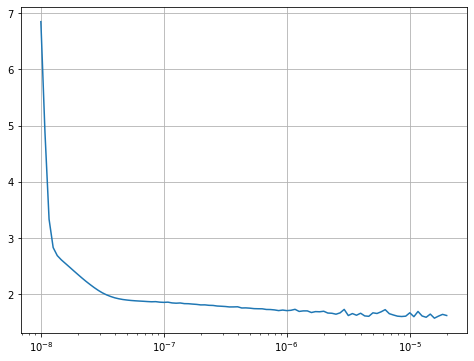

In [23]:
## plot the loss against the learning rate

metrics = pd.DataFrame(model.history.history)
metrics


plt.figure(figsize =(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.show();

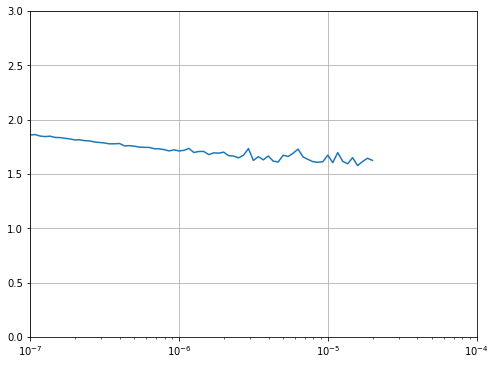

In [25]:
plt.figure(figsize =(8,6))
plt.semilogx(metrics['lr'], metrics['loss'])
plt.grid(True)
plt.axis([1e-7, 1e-4, 0,3])
plt.show();

### Retrain the model with the learning rate 

In [16]:
## set back to the initial weights

model.set_weights(init_weights)

In [17]:
## Set up the learning rate parameter

# choosing learning rate to be 1e-5
learning_rate = 1e-5

# compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9),
             loss=tf.keras.losses.Huber(),
             metrics = ['mae'])

# fit model
model.fit(train_dataset, epochs=200)

Epoch 1/200
46/46 [==============================] - 7s 92ms/step - loss: 5.1401 - mae: 5.6049
Epoch 2/200
46/46 [==============================] - 4s 82ms/step - loss: 1.7947 - mae: 2.2426
Epoch 3/200
46/46 [==============================] - 3s 65ms/step - loss: 1.7399 - mae: 2.1916
Epoch 4/200
46/46 [==============================] - 3s 69ms/step - loss: 1.8069 - mae: 2.2607
Epoch 5/200
46/46 [==============================] - 3s 70ms/step - loss: 1.7137 - mae: 2.1629
Epoch 6/200
46/46 [==============================] - 4s 74ms/step - loss: 1.7033 - mae: 2.1550
Epoch 7/200
46/46 [==============================] - 3s 69ms/step - loss: 1.7072 - mae: 2.1548
Epoch 8/200
46/46 [==============================] - 4s 77ms/step - loss: 1.6803 - mae: 2.1285
Epoch 9/200
46/46 [==============================] - 4s 78ms/step - loss: 1.7177 - mae: 2.1671
Epoch 10/200
46/46 [==============================] - 5s 93ms/step - loss: 1.6681 - mae: 2.1172
Epoch 11/200
46/46 [=============================

46/46 [==============================] - 4s 77ms/step - loss: 1.4995 - mae: 1.9426
Epoch 87/200
46/46 [==============================] - 4s 74ms/step - loss: 1.4868 - mae: 1.9278
Epoch 88/200
46/46 [==============================] - 3s 70ms/step - loss: 1.4988 - mae: 1.9401
Epoch 89/200
46/46 [==============================] - 4s 75ms/step - loss: 1.5325 - mae: 1.9759
Epoch 90/200
46/46 [==============================] - 4s 71ms/step - loss: 1.5151 - mae: 1.9575
Epoch 91/200
46/46 [==============================] - 4s 75ms/step - loss: 1.5411 - mae: 1.9865
Epoch 92/200
46/46 [==============================] - 4s 78ms/step - loss: 1.4921 - mae: 1.9325
Epoch 93/200
46/46 [==============================] - 4s 80ms/step - loss: 1.5134 - mae: 1.9568
Epoch 94/200
46/46 [==============================] - 4s 78ms/step - loss: 1.4990 - mae: 1.9410
Epoch 95/200
46/46 [==============================] - 4s 79ms/step - loss: 1.4990 - mae: 1.9407
Epoch 96/200
46/46 [==============================] -

46/46 [==============================] - 3s 66ms/step - loss: 1.4869 - mae: 1.9272
Epoch 171/200
46/46 [==============================] - 3s 67ms/step - loss: 1.4637 - mae: 1.9013
Epoch 172/200
46/46 [==============================] - 3s 66ms/step - loss: 1.5220 - mae: 1.9670
Epoch 173/200
46/46 [==============================] - 3s 65ms/step - loss: 1.4854 - mae: 1.9289
Epoch 174/200
46/46 [==============================] - 3s 68ms/step - loss: 1.5254 - mae: 1.9705
Epoch 175/200
46/46 [==============================] - 3s 68ms/step - loss: 1.4870 - mae: 1.9312
Epoch 176/200
46/46 [==============================] - 3s 71ms/step - loss: 1.5191 - mae: 1.9632
Epoch 177/200
46/46 [==============================] - 3s 70ms/step - loss: 1.4821 - mae: 1.9228
Epoch 178/200
46/46 [==============================] - 4s 75ms/step - loss: 1.4728 - mae: 1.9121
Epoch 179/200
46/46 [==============================] - 3s 68ms/step - loss: 1.4954 - mae: 1.9376
Epoch 180/200
46/46 [=======================

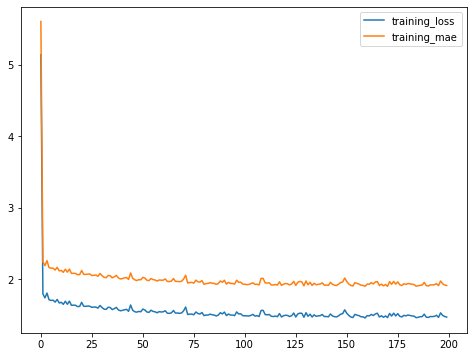

In [22]:
# plot and check

metrics = pd.DataFrame(model.history.history)
metrics


epoch_range = range(200)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'], label = 'training_loss')
plt.plot(epoch_range, metrics['mae'], label = 'training_mae')
plt.legend(loc='best')
plt.show();

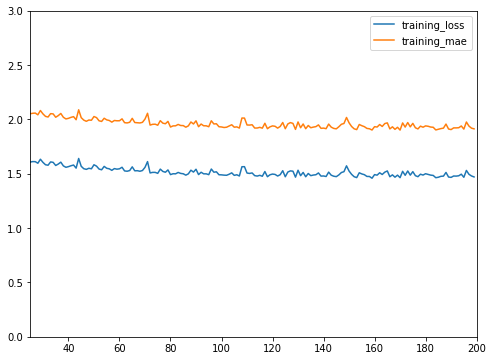

In [21]:
epoch_range = range(200)
plt.figure(figsize=(8,6))
plt.plot(epoch_range, metrics['loss'], label = 'training_loss')
plt.plot(epoch_range, metrics['mae'], label = 'training_mae')
plt.axis([25,200, 0, 3])
plt.legend(loc='best')
plt.show();

### validation

In [25]:
## define prediction function

def get_prediction(model, series, batch_size, window_size):
    
    # generate data
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # window
    dataset = dataset.window(size=window_size, shift=1, drop_remainder=True)
    
    # flatten the data
    dataset = dataset.flat_map(lambda window:window.batch(window_size))
    
    # batch 
    dataset = dataset.batch(batch_size=batch_size).prefetch(1)
    
    # get prediction
    predictions = model.predict(dataset)
    
    return predictions

12/12 [==============================] - 1s 39ms/step


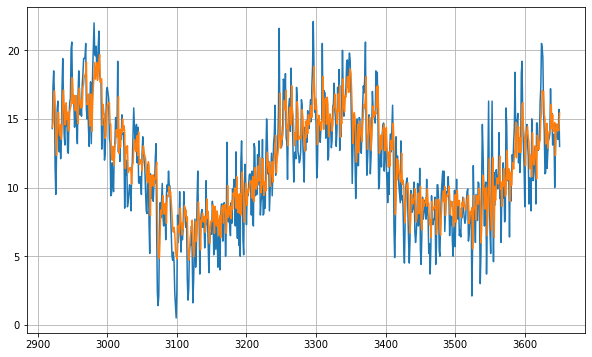

In [26]:
## prepare forecasts data and get predictions

forecast_data = series[split_time - window_size: -1]

forecasts = get_prediction(model, forecast_data, batch_size, window_size)

## squeeze the forecasts
results = forecasts.squeeze()

# plot and check
plot_series(valid_time, (valid_series, results))

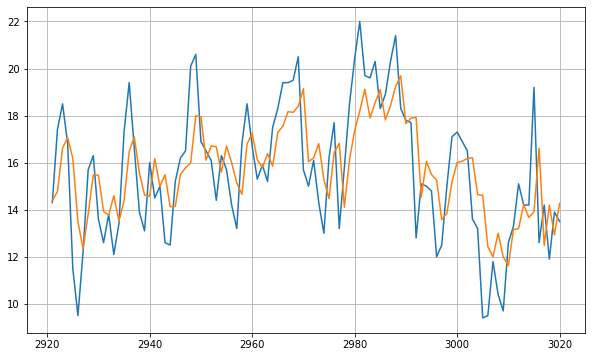

In [32]:
# plot and check
plot_series(valid_time, (valid_series, results), start=0, end=100)

In [27]:
## get metrics function

def get_metrics(true_value, predicted_value):
    
    print('Mean Squared Error : {}'.format(tf.keras.metrics.mean_squared_error(true_value, predicted_value).numpy()))
    print('Mean Absolute Error : {}'.format(tf.keras.metrics.mean_absolute_error(true_value, predicted_value).numpy()))

In [28]:
get_metrics(valid_series, results)

Mean Squared Error : 5.0013813972473145
Mean Absolute Error : 1.7606674432754517
